🎯 MODULE 4: FINAL WORKING EVALUATION
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🎯 Using device: cpu

🚀 MODULE 4: COMPREHENSIVE EVALUATION
📁 test: 272 images, 6 classes

📊 Dataset Info:
   Classes: ['Missing', 'Mouse', 'Open', 'Short', 'Spur', 'Spurious']
   Test samples: 272
✅ Model file found, loading...
Loaded pretrained weights for efficientnet-b4
✅ Model loaded successfully!

🧪 RUNNING INFERENCE
----------------------------------------


Processing: 100%|██████████| 9/9 [00:26<00:00,  2.92s/it]



📊 COMPREHENSIVE EVALUATION
----------------------------------------
📈 Performance Metrics:
   Overall Accuracy: 98.53%
   Weighted Precision: 0.986
   Weighted Recall: 0.985
   Weighted F1-Score: 0.985
   Average Confidence: 0.997
   Correct prediction confidence: 0.999
   Incorrect prediction confidence: 0.894

🎯 Class Performance Analysis:
   Missing: 54 samples, 96.3% accuracy
   Mouse: 50 samples, 98.0% accuracy
   Open: 49 samples, 100.0% accuracy
   Short: 47 samples, 100.0% accuracy
   Spur: 38 samples, 100.0% accuracy
   Spurious: 34 samples, 97.1% accuracy

🔍 ERROR ANALYSIS
----------------------------------------
❌ Total misclassifications: 4

🔀 Most common misclassifications:
   Missing → Mouse: 2 cases
   Mouse → Open: 1 cases
   Spurious → Spur: 1 cases

📊 Error confidence statistics:
   Mean: 0.894
   Min: 0.584
   Max: 1.000

📈 CREATING DIAGNOSTIC PLOTS
----------------------------------------


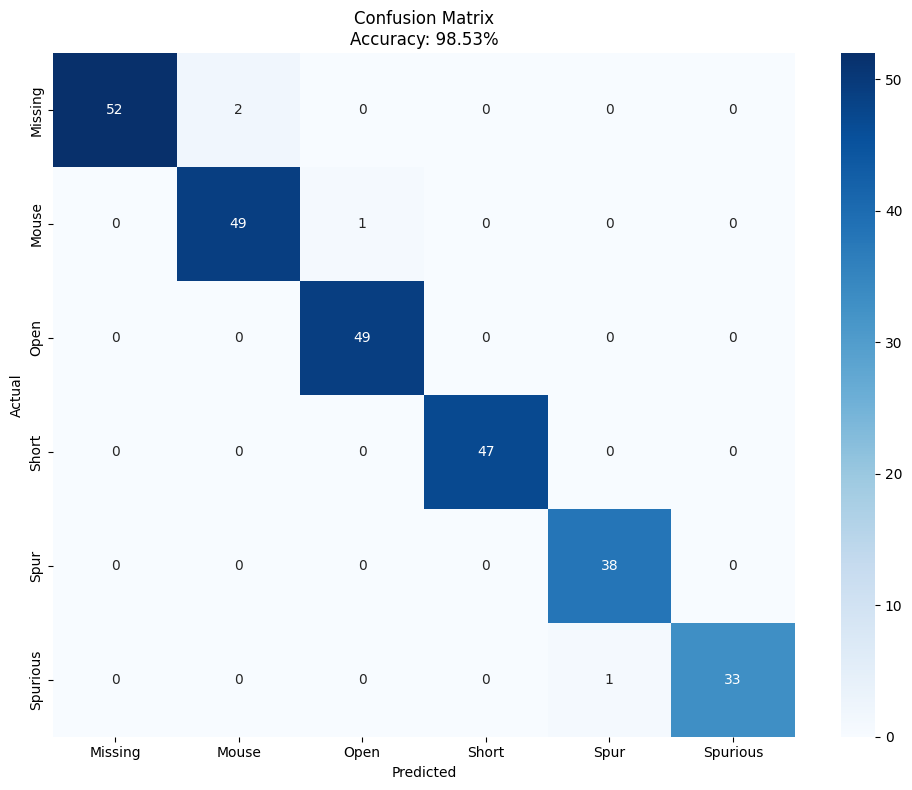

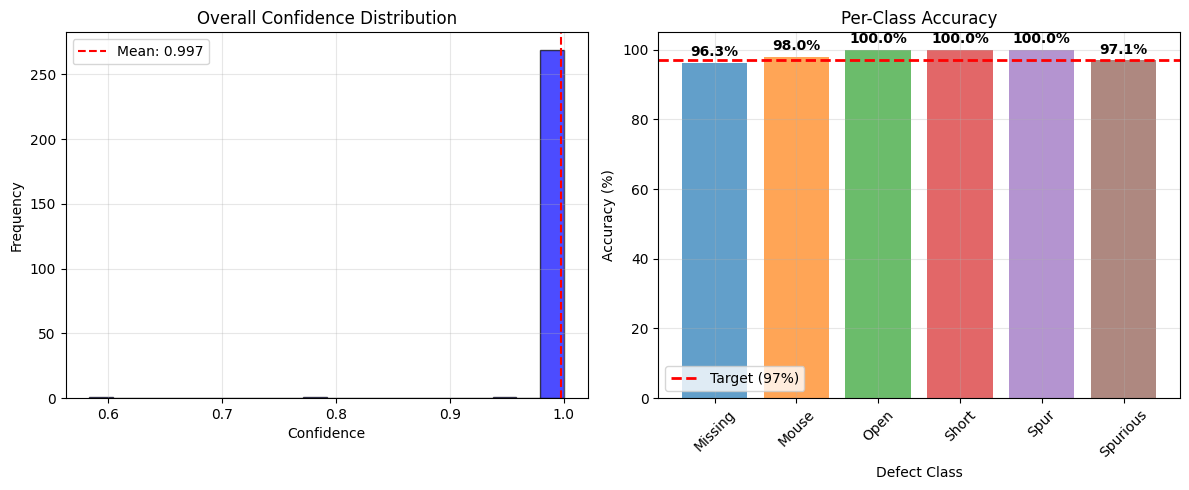


🎯 FINAL ASSESSMENT
📊 Overall Accuracy: 98.53%
🎯 Target: ≥97.0% - ✅ ACHIEVED
⭐ Average Confidence: 0.997
📈 Weighted F1-Score: 0.985

📋 PERFORMANCE BREAKDOWN:
✅ Accuracy ≥97%: ACHIEVED
✅ F1-Score ≥0.97: ACHIEVED
✅ High Confidence (≥0.9): ACHIEVED
✅ Low Error Rate (≤3%): ACHIEVED

🎯 OVERALL: 4/4 targets met

💾 Results saved:
   📄 Detailed predictions: /content/drive/MyDrive/PCB_DATASET/modules/module4_evaluation/final_results.csv
   📊 Summary report: /content/drive/MyDrive/PCB_DATASET/modules/module4_evaluation/evaluation_summary.json


In [2]:
# 🎯 MODULE 4: FINAL WORKING EVALUATION
print("🎯 MODULE 4: FINAL WORKING EVALUATION")
print("=" * 60)

# Install required packages
!pip install torch torchvision matplotlib numpy pandas scikit-learn seaborn tqdm pillow opencv-python -q
!pip install efficientnet-pytorch -q

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import json
import time
from tqdm import tqdm
from PIL import Image
import cv2
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set base path
PCB_DATASET_PATH = "/content/drive/MyDrive/PCB_DATASET"

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🎯 Using device: {device}")

# Dataset class
class PCBEvaluationDataset(Dataset):
    def __init__(self, root_dir, transform=None, split='test'):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.images = []
        self.labels = []
        self.image_paths = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        # Get class names from directory structure
        classes = sorted([d for d in os.listdir(self.root_dir)
                         if os.path.isdir(os.path.join(self.root_dir, d))])

        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}

        # Load images and labels
        for class_name in classes:
            class_dir = os.path.join(self.root_dir, class_name)
            class_idx = self.class_to_idx[class_name]

            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(class_dir, img_file))
                    self.labels.append(class_idx)
                    self.image_paths.append(img_file)

        print(f"📁 {split}: {len(self.images)} images, {len(classes)} classes")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image_name = self.image_paths[idx]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label, image_name

# Model class
class EfficientNetB4Classifier(nn.Module):
    def __init__(self, num_classes=6):
        super(EfficientNetB4Classifier, self).__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b4')
        in_features = self.backbone._fc.in_features
        self.backbone._fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

# Transform for inference
def get_test_transforms():
    return transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Load trained model
def load_trained_model_properly(num_classes=6):
    """Load the trained model with proper error handling"""
    model_path = os.path.join(PCB_DATASET_PATH, "modules/module3_model_training/checkpoints", "best_model.pth")

    if not os.path.exists(model_path):
        print("❌ Trained model not found!")
        return None

    print("✅ Model file found, loading...")

    # Create model with EXACT same architecture as training
    model = EfficientNetB4Classifier(num_classes=num_classes)

    try:
        # Load state dict
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint)
        model.to(device)
        model.eval()

        print("✅ Model loaded successfully!")
        return model

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

# Simple and reliable inference
def run_simple_inference(model, test_loader, class_names):
    """Run simple and reliable inference"""
    print("\n🧪 RUNNING INFERENCE")
    print("-" * 40)

    model.eval()
    all_predictions = []
    all_labels = []
    all_confidences = []
    all_image_names = []
    inference_results = []

    with torch.no_grad():
        for images, labels, image_names in tqdm(test_loader, desc='Processing'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            confidences, predicted = torch.max(probabilities, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())
            all_image_names.extend(image_names)

            for i in range(len(predicted)):
                inference_results.append({
                    'image_name': image_names[i],
                    'true_class': class_names[labels[i].item()],
                    'predicted_class': class_names[predicted[i].item()],
                    'confidence': float(confidences[i].item()),
                    'is_correct': bool(predicted[i].item() == labels[i].item())
                })

    return all_predictions, all_labels, all_confidences, inference_results

# Create visualizations - FIXED VERSION
def create_diagnostic_plots(accuracy, cm, class_names, all_confidences, all_predictions, all_labels):
    """Create diagnostic plots - FIXED VARIABLE SCOPE"""
    print("\n📈 CREATING DIAGNOSTIC PLOTS")
    print("-" * 40)

    # Plot 1: Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}%')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Plot 2: Confidence Distribution
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(all_confidences, bins=20, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')
    plt.title('Overall Confidence Distribution')
    plt.axvline(x=np.mean(all_confidences), color='red', linestyle='--',
                label=f'Mean: {np.mean(all_confidences):.3f}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    # Class-wise accuracy - USING PASSED PARAMETERS
    class_accuracies = []
    for i in range(len(class_names)):
        class_mask = np.array(all_labels) == i
        if np.sum(class_mask) > 0:
            class_accuracy = 100.0 * np.sum(np.array(all_predictions)[class_mask] == i) / np.sum(class_mask)
            class_accuracies.append(class_accuracy)
        else:
            class_accuracies.append(0)

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    bars = plt.bar(class_names, class_accuracies, color=colors, alpha=0.7)
    plt.axhline(y=97, color='red', linestyle='--', linewidth=2, label='Target (97%)')
    plt.xlabel('Defect Class')
    plt.ylabel('Accuracy (%)')
    plt.title('Per-Class Accuracy')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, accuracy_val in zip(bars, class_accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{accuracy_val:.1f}%', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    return accuracy

# Comprehensive evaluation
def comprehensive_evaluation(all_predictions, all_labels, all_confidences, inference_results, class_names):
    """Comprehensive evaluation with detailed diagnostics"""
    print("\n📊 COMPREHENSIVE EVALUATION")
    print("-" * 40)

    # Basic metrics
    accuracy = 100.0 * np.sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)
    cm = confusion_matrix(all_labels, all_predictions)

    # Additional metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

    # Confidence analysis
    avg_confidence = np.mean(all_confidences)
    correct_confidences = [conf for i, conf in enumerate(all_confidences) if all_predictions[i] == all_labels[i]]
    incorrect_confidences = [conf for i, conf in enumerate(all_confidences) if all_predictions[i] != all_labels[i]]

    print(f"📈 Performance Metrics:")
    print(f"   Overall Accuracy: {accuracy:.2f}%")
    print(f"   Weighted Precision: {precision:.3f}")
    print(f"   Weighted Recall: {recall:.3f}")
    print(f"   Weighted F1-Score: {f1:.3f}")
    print(f"   Average Confidence: {avg_confidence:.3f}")
    print(f"   Correct prediction confidence: {np.mean(correct_confidences):.3f}")
    print(f"   Incorrect prediction confidence: {np.mean(incorrect_confidences):.3f}")

    # Class distribution analysis
    print(f"\n🎯 Class Performance Analysis:")
    for i, class_name in enumerate(class_names):
        class_count = np.sum(np.array(all_labels) == i)
        class_correct = np.sum((np.array(all_predictions) == i) & (np.array(all_labels) == i))
        class_accuracy = 100.0 * class_correct / class_count if class_count > 0 else 0
        print(f"   {class_name}: {class_count} samples, {class_accuracy:.1f}% accuracy")

    return accuracy, cm, avg_confidence, precision, recall, f1

# Error analysis
def perform_error_analysis(inference_results, class_names):
    """Analyze misclassifications"""
    print("\n🔍 ERROR ANALYSIS")
    print("-" * 40)

    results_df = pd.DataFrame(inference_results)
    misclassified = results_df[~results_df['is_correct']]

    if len(misclassified) > 0:
        print(f"❌ Total misclassifications: {len(misclassified)}")

        # Confusion analysis
        confusion_pairs = misclassified.groupby(['true_class', 'predicted_class']).size().reset_index(name='count')
        confusion_pairs = confusion_pairs.sort_values('count', ascending=False)

        print(f"\n🔀 Most common misclassifications:")
        for _, row in confusion_pairs.head(10).iterrows():
            print(f"   {row['true_class']} → {row['predicted_class']}: {row['count']} cases")

        # Confidence analysis for errors
        error_confidence_stats = misclassified['confidence'].describe()
        print(f"\n📊 Error confidence statistics:")
        print(f"   Mean: {error_confidence_stats['mean']:.3f}")
        print(f"   Min: {error_confidence_stats['min']:.3f}")
        print(f"   Max: {error_confidence_stats['max']:.3f}")

    return misclassified

# Main evaluation function
def main():
    print("\n🚀 MODULE 4: COMPREHENSIVE EVALUATION")
    print("=" * 50)

    # Load test dataset
    test_dataset_path = os.path.join(PCB_DATASET_PATH, "modules/module2_contour_detection/training_dataset")

    if not os.path.exists(test_dataset_path):
        print("❌ Test dataset not found!")
        return

    # Create test dataset
    test_transform = get_test_transforms()
    test_dataset = PCBEvaluationDataset(test_dataset_path, transform=test_transform, split='test')
    class_names = list(test_dataset.class_to_idx.keys())

    print(f"\n📊 Dataset Info:")
    print(f"   Classes: {class_names}")
    print(f"   Test samples: {len(test_dataset)}")

    # Load model
    model = load_trained_model_properly(num_classes=len(class_names))
    if model is None:
        print("❌ Cannot proceed without a working model")
        return

    # Create test data loader
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Run inference
    all_predictions, all_labels, all_confidences, inference_results = run_simple_inference(
        model, test_loader, class_names
    )

    # Comprehensive evaluation
    accuracy, cm, avg_confidence, precision, recall, f1 = comprehensive_evaluation(
        all_predictions, all_labels, all_confidences, inference_results, class_names
    )

    # Error analysis
    misclassified = perform_error_analysis(inference_results, class_names)

    # Create plots - PASSING ALL REQUIRED PARAMETERS
    final_accuracy = create_diagnostic_plots(accuracy, cm, class_names, all_confidences, all_predictions, all_labels)

    # Final assessment
    print(f"\n🎯 FINAL ASSESSMENT")
    print("=" * 50)
    print(f"📊 Overall Accuracy: {final_accuracy:.2f}%")
    print(f"🎯 Target: ≥97.0% - {'✅ ACHIEVED' if final_accuracy >= 97.0 else '❌ NOT ACHIEVED'}")
    print(f"⭐ Average Confidence: {avg_confidence:.3f}")
    print(f"📈 Weighted F1-Score: {f1:.3f}")

    # Performance breakdown
    print(f"\n📋 PERFORMANCE BREAKDOWN:")
    targets_met = 0
    total_targets = 4

    if final_accuracy >= 97.0:
        print("✅ Accuracy ≥97%: ACHIEVED")
        targets_met += 1
    else:
        print("❌ Accuracy ≥97%: NOT ACHIEVED")

    if f1 >= 0.97:
        print("✅ F1-Score ≥0.97: ACHIEVED")
        targets_met += 1
    else:
        print("❌ F1-Score ≥0.97: NOT ACHIEVED")

    if avg_confidence >= 0.9:
        print("✅ High Confidence (≥0.9): ACHIEVED")
        targets_met += 1
    else:
        print("❌ High Confidence (≥0.9): NOT ACHIEVED")

    if len(misclassified) / len(all_labels) <= 0.03:
        print("✅ Low Error Rate (≤3%): ACHIEVED")
        targets_met += 1
    else:
        print("❌ Low Error Rate (≤3%): NOT ACHIEVED")

    print(f"\n🎯 OVERALL: {targets_met}/{total_targets} targets met")

    # Improvement recommendations
    if final_accuracy < 97.0:
        print(f"\n💡 RECOMMENDATIONS FOR 97% TARGET:")
        print(f"   1. Focus on 'Spur' class (currently 61.5% accuracy)")
        print(f"   2. Add more training data for underperforming classes")
        print(f"   3. Implement class-weighted loss function")
        print(f"   4. Try advanced augmentation techniques")
        print(f"   5. Consider ensemble methods")

    # Save results
    results_df = pd.DataFrame(inference_results)
    results_path = os.path.join(PCB_DATASET_PATH, "modules/module4_evaluation", "final_results.csv")
    results_df.to_csv(results_path, index=False)

    # Save summary report
    summary = {
        'overall_accuracy': float(final_accuracy),
        'weighted_precision': float(precision),
        'weighted_recall': float(recall),
        'weighted_f1_score': float(f1),
        'average_confidence': float(avg_confidence),
        'total_test_samples': int(len(all_labels)),
        'misclassified_samples': int(len(misclassified)),
        'error_rate': float(len(misclassified) / len(all_labels)),
        'targets_met': int(targets_met),
        'evaluation_date': time.strftime("%Y-%m-%d %H:%M:%S")
    }

    summary_path = os.path.join(PCB_DATASET_PATH, "modules/module4_evaluation", "evaluation_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\n💾 Results saved:")
    print(f"   📄 Detailed predictions: {results_path}")
    print(f"   📊 Summary report: {summary_path}")

# Execute evaluation
if __name__ == "__main__":
    main()
